Calculates reliability of PPI statements from INDRA Benchmark Corpus and compares to BioGRID.

In [1]:
import pickle
import logging
from os.path import join

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier

from indra import belief
from indra.belief.skl import CountsScorer
from indra.tools import assemble_corpus as ac
from indra.statements import Complex, Phosphorylation
from indra.ontology.bio import bio_ontology as bo
from indra.preassembler import Preassembler
from indra.util import plot_formatting as pf
from indra.sources.biogrid import BiogridProcessor

%matplotlib notebook

opath = '../output/'
prefix = 'fig5_ipynb'

def fig_path(name, fmt):
    return join(opath, f'{prefix}_{name}.{fmt}')

logger = logging.getLogger('biogrid_benchmark')

readers = ('reach', 'sparser', 'medscan', 'rlimsp', 'trips', 'isi')

# Load curation and statement data

Load the curation dataset and the preassembled statements.

In [2]:
def load_curation_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
        df = pd.DataFrame.from_records(dataset)
        df = df.fillna(0)
    # Every column except agent names and stmt type should be int
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('agA_name', 'agA_ns', 'agA_id', 'stmt_type',
                                 'agB_name', 'agB_ns', 'agB_id')}
    df = df.astype(dtype_dict)
    return df

def filter_out_db_only(stmts):
    filt_stmts = []
    for stmt in stmts:
        sources = set([ev.source_api for ev in stmt.evidence])
        # Ignore any statements that don't have at least one reader as evidence
        if sources.intersection(readers):
            filt_stmts.append(stmt)
    return filt_stmts
           
# Get dataset of curated statements along with correctness values
def stmts_for_df(df, stmts_by_hash):
    stmt_list = []
    for row in df.itertuples():
        stmt_hash = row.stmt_hash
        stmt_list.append(stmts_by_hash[stmt_hash])
    return stmt_list

In [3]:
# Load pickle of assembled statements.
indra_stmts = ac.load_statements('../data/bioexp_asmb_preassembled.pkl')

# Filter out any statements with only database evidence
indra_stmts = filter_out_db_only(indra_stmts)

# Index the statements by hash
stmts_by_hash = {s.get_hash(): s for s in indra_stmts}

# Load the statement curation data
curation_data_file = 'curation_dataset_with_bg_psp.pkl'
kge_df = load_curation_data(curation_data_file)

# Get statements from curation dataframe
kge_stmts = stmts_for_df(kge_df, stmts_by_hash)

y_arr = kge_df['correct'].values

INFO: [2022-08-10 01:26:05] indra.tools.assemble_corpus - Loading ../data/bioexp_asmb_preassembled.pkl...
INFO: [2022-08-10 01:27:04] indra.tools.assemble_corpus - Loaded 895580 statements


# Fit model to all curation data

In [4]:
# The best performing Belief model makes use of evidence directly supporting
# a particular statement and the evidence from more specific statements.
extra_evidence = belief.get_ev_for_stmts_from_supports(kge_stmts)

# Use a Random Forest model
clf = RandomForestClassifier(n_estimators=2000, max_depth=13)

# Provide all available features as well as the more specific evidences.
# However, limit the source evidence to only what is obtained from readers
# (to focus the results on the impact of assembled machine reading output
# on curation)
scorer = CountsScorer(
    clf, readers, use_stmt_type=True, use_num_pmids=True,
    use_promoter=True, use_avg_evidence_len=True, include_more_specific=True)

# Train the model on the curated data
scorer.fit(kge_stmts, y_arr, extra_evidence)

INFO: [2022-08-10 01:27:22] indra.belief.skl - source_list does not include all source_apis in the statement data.


# Biogrid Benchmark

Load the Biogrid statements:

In [35]:
reload = False

bg_stmts_file = join(opath, 'bg_stmts_asmb_updated_tab3.pkl')

# Can obtain this file by running
# wget https://downloads.thebiogrid.org/Download/BioGRID/Release-Archive/BIOGRID-4.2.192/BIOGRID-ALL-4.2.192.tab3.zip
# and
# unzip BIOGRID-ALL-4.2.192.tab3.zip
# ...in the notebooks directory
biogrid_file = 'BIOGRID-ALL-4.2.192.tab3.txt'

if reload:
    bp = BiogridProcessor(biogrid_file=biogrid_file, physical_only=True)
    bg_stmts_raw = bp.statements
    # De-duplicate the Biogrid statements
    pa = Preassembler(bo, stmts=bg_stmts_raw)
    bg_stmts_asmb = pa.combine_duplicates()
    # Save statements to file
    with open(bg_stmts_file, 'wb') as f:
        pickle.dump(bg_stmts_asmb, f)
else:
    with open(bg_stmts_file, 'rb') as f:
        bg_stmts_asmb = pickle.load(f)

Filter both the INDRA-assembled and Biogrid statements to Complexes of human genes:

In [39]:
def filter_stmts(stmts, stmt_type):
    stmts = ac.filter_by_type(stmts, stmt_type)
    stmts = ac.filter_genes_only(stmts, specific_only=True)
    stmts = ac.filter_human_only(stmts)
    stmts = [s for s in stmts if None not in [ag for ag in s.agent_list()]]
    return stmts

# Filter to Complex of human genes
bg_stmts_filt = filter_stmts(bg_stmts_asmb, Complex)
indra_stmts_filt_cplx = filter_stmts(indra_stmts, Complex)

INFO: [2022-08-11 00:47:04] indra.tools.assemble_corpus - Filtering 886283 statements for type Complex...
INFO: [2022-08-11 00:47:07] indra.tools.assemble_corpus - 886283 statements after filter...
INFO: [2022-08-11 00:47:07] indra.tools.assemble_corpus - Filtering 886283 statements for ones containing genes only...
INFO: [2022-08-11 00:47:17] indra.tools.assemble_corpus - 843285 statements after filter...
INFO: [2022-08-11 00:47:17] indra.tools.assemble_corpus - Filtering 843285 statements for human genes only...
INFO: [2022-08-11 00:47:27] indra.tools.assemble_corpus - 484719 statements after filter...
INFO: [2022-08-11 00:47:29] indra.tools.assemble_corpus - Filtering 734208 statements for type Complex...
INFO: [2022-08-11 00:47:31] indra.tools.assemble_corpus - 166703 statements after filter...
INFO: [2022-08-11 00:47:31] indra.tools.assemble_corpus - Filtering 166703 statements for ones containing genes only...
INFO: [2022-08-11 00:47:37] indra.tools.assemble_corpus - 127300 state

Use the trained belief model to assign belief values to statements:

In [10]:
belief_engine = belief.BeliefEngine(scorer)
belief_engine.set_hierarchy_probs(indra_stmts_filt_cplx)

INFO: [2022-08-10 01:48:04] indra.belief.skl - source_list does not include all source_apis in the statement data.


Group indra stmts by belief bin and get counts and statements for the ones in BioGRID vs. not in BioGRID:


In [11]:
def stmts_in_bg_by_belief(stmts, bg_hashes, bin_info, stmts_by_hash):
    in_bg = np.zeros(len(bin_info))
    not_in_bg = np.zeros(len(bin_info))
    in_bg_stmts = {}
    not_in_bg_stmts = {}
    for i, (lbound, ubound, label) in enumerate(bin_info):
        stmts_by_belief = [s for s in stmts
                           if s.belief > lbound and s.belief <= ubound]
        bin_hashes = set([s.get_hash(refresh=True) for s in stmts_by_belief])
        in_bg_hashes = bin_hashes.intersection(bg_hashes)
        not_in_bg_hashes = bin_hashes.difference(in_bg_hashes)

        in_bg[i] = len(in_bg_hashes)
        not_in_bg[i] = len(not_in_bg_hashes)
        in_bg_stmts[label] = [stmts_by_hash[h] for h in in_bg_hashes]
        not_in_bg_stmts[label] = [stmts_by_hash[h] for h in not_in_bg_hashes]
    return {'in_bg_cts': in_bg,
            'not_in_bg_cts': not_in_bg,
            'in_bg_stmts': in_bg_stmts,
            'not_in_bg_stmts': not_in_bg_stmts}


# Set belief bin bounds for comparison with BioGRID

def get_bin_info(bin_bounds):
     return [(bin_bounds[i], bin_bounds[i+1],
             f'{bin_bounds[i]}_{bin_bounds[i+1]}')
             for i in range(len(bin_bounds) - 1)]

bin_bounds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]
bin_info = get_bin_info(bin_bounds)

# Get statement hashes for BioGRID and INDRA statements for comparison
bg_hashes = set([s.get_hash(refresh=True) for s in bg_stmts_filt])
indra_hashes_cplx = set([s.get_hash(refresh=True) for s in indra_stmts_filt_cplx])

# Get a dict with info on the statements in/not in BioGRID
in_bg_info = stmts_in_bg_by_belief(indra_stmts_filt_cplx, bg_hashes,
                                   bin_info, stmts_by_hash)


How many unique Statements represented by BioGRID PPIs?

In [97]:
len(bg_hashes)

479560

Plot belief distribution along with BG/not in BG status:

<IPython.core.display.Javascript object>


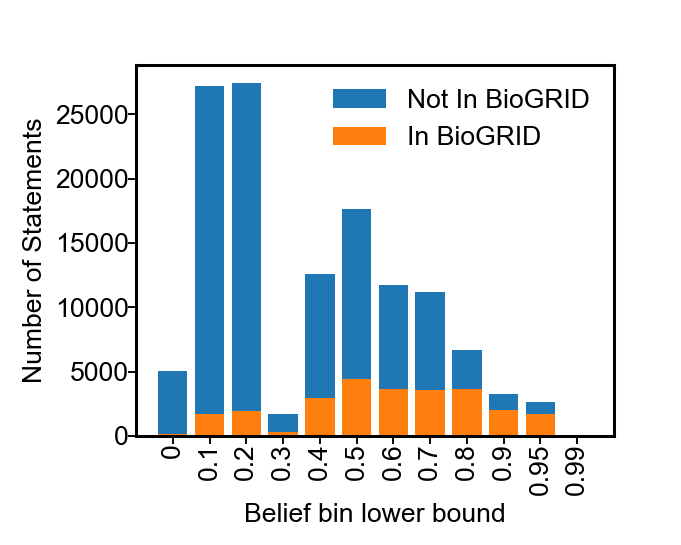

[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]


In [12]:
# Plot statement counts
def plot_in_db(in_db_dict, bin_info, db_name):
    index = np.array(range(len(bin_info)))
    fig = plt.figure(figsize=(2.5, 2), dpi=150)
    plt.bar(index, in_db_dict['not_in_bg_cts'],
            bottom=in_db_dict['in_bg_cts'], label=f'Not In {db_name}')
    plt.bar(index, in_db_dict['in_bg_cts'], label=f'In {db_name}')
    ax = plt.gca()
    ax.set_xticks(index)
    tls = [lb for lb, _, _ in bin_info]
    print(tls)
    ax.set_xticklabels(tls, rotation='vertical')
    pf.format_axis(ax)
    plt.ylabel('Number of Statements')
    plt.xlabel('Belief bin lower bound')
    pf.format_axis(ax)

    plt.legend(loc='upper right', fontsize=pf.fontsize, frameon=False)
    plt.subplots_adjust(bottom=0.2, left=0.2)
    return fig
    
# Make the plot and save
fig = plot_in_db(in_bg_info, bin_info, 'BioGRID')
plt.savefig(fig_path('in_bg_cts', 'pdf'))

Plot the proportion of statements in each bin in Biogrid:

<IPython.core.display.Javascript object>


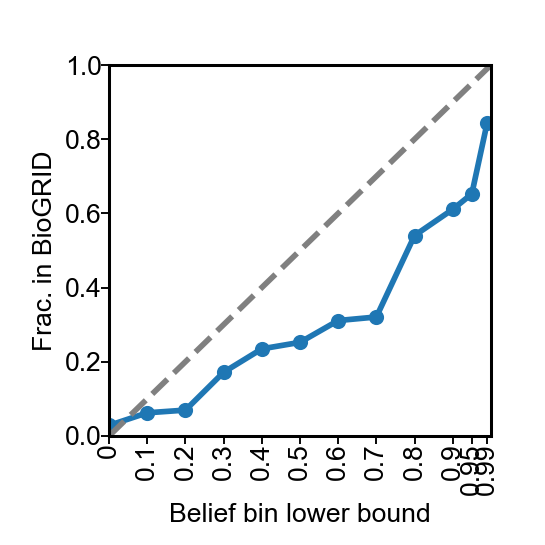

[(0, 0.028288822947576658), (0.1, 0.06230483817640792), (0.2, 0.0695582504825376), (0.3, 0.17162872154115585), (0.4, 0.2347205707491082), (0.5, 0.2522578812837262), (0.6, 0.3110714589174951), (0.7, 0.32063321706466325), (0.8, 0.5402539208364451), (0.9, 0.6108555657773689), (0.95, 0.6525229357798165), (0.99, 0.8431372549019608)]


In [13]:
def plot_frac_in_db(in_db_dict, bin_info, db_name):
    fracs_in_db = []
    lbs = []
    for i, (lb, _, _) in enumerate(bin_info):
        numer = in_db_dict['in_bg_cts'][i]
        denom = in_db_dict['not_in_bg_cts'][i] + numer
        # If there are no statements in this bin, skip it
        if denom == 0:
            continue
        lbs.append(lb)
        fracs_in_db.append(numer / denom)

    # Plot statement percentages
    fig = plt.figure(figsize=(2, 2), dpi=150)
    print(list(zip(lbs, fracs_in_db)))
    plt.plot(lbs, fracs_in_db, marker='.')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax = plt.gca()
    ax.set_xticks(lbs)
    ax.set_xticklabels(lbs, rotation='vertical')
    pf.format_axis(ax)
    plt.ylabel(f'Frac. in {db_name}')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.xlabel('Belief bin lower bound')
    plt.subplots_adjust(bottom=0.2, left=0.2)
    return fig

# Make the plot
fig = plot_frac_in_db(in_bg_info, bin_info, 'BioGRID')
plt.savefig(fig_path('in_bg_pct', 'pdf'))

### Estimate total number of true positive statements

The total number of extracted statements:

In [14]:
len(indra_stmts_filt_cplx)

127292

How many statements in BioGRID?

In [92]:
num_in_bg = len([s for bg_stmts in in_bg_info['in_bg_stmts'].values() for s in bg_stmts])
num_in_bg

26093

How many statements not in BioGRID?

In [93]:
all_not_in_bg_stmts = [s for bel_bin, bel_stmts in in_bg_info['not_in_bg_stmts'].items()
                         for s in bel_stmts]
len(all_not_in_bg_stmts)

101199

First way to calculate the number of correct but uncurated Statements.
Get the expected number of true statements:

In [15]:
expect_true = np.sum([s.belief for s in indra_stmts_filt_cplx])
expect_true

54700.68310052375

The subtract away the number in BioGRID (assuming all Statements in BioGRID are correct, which may not always be the case), leaving behind the residual number of correct Statements:

In [17]:
expect_true - num_in_bg

28607.683100523747

As a proportion relative to the size of BioGRID:

In [98]:
(expect_true - num_in_bg) / len(bg_hashes)

0.059654022646850755

As an upper bound, we treat the probability of correctness as independent of Statements being in BioGRID or not, and simply use the belief to calculate the expected number of true Statements among the Statements not in BioGRID:

In [99]:
expect_true_indep = np.sum([s.belief for s in all_not_in_bg_stmts])
expect_true_indep

38335.964391598485

As a proportion relative to the size of BioGRID:

In [100]:
expect_true_indep / len(bg_hashes)

0.07993987069730271

Fraction of PPIs in BG:

In [96]:
frac_not_in_bg = len(all_not_in_bg_stmts) / len(indra_stmts_filt_cplx)
frac_correct = expect_true / len(indra_stmts_filt_cplx)
indep_corr_not_bg = frac_not_in_bg * frac_correct * len(indra_stmts_filt_cplx)
indep_corr_not_bg

43487.84235529258

## Return on curation effort

For each bin, figure out how many expected true but uncurated statements there are. 

In [21]:
bins_reversed = bin_info[::-1]
bin_ix_rev = list(range(len(bins_reversed)))[::-1]
num_rev = [0]
num_found = [0]
for (bin_ix, (bin_lb, bin_ub, bin_lbl)) in zip(bin_ix_rev, bins_reversed):
    num_bg = in_bg_info['in_bg_cts'][bin_ix]
    num_not_bg = in_bg_info['not_in_bg_cts'][bin_ix]
    bin_expect = np.sum([s.belief for s in in_bg_info['not_in_bg_stmts'][bin_lbl]] +
                        [s.belief for s in in_bg_info['in_bg_stmts'][bin_lbl]])
    bin_delta = bin_expect - num_bg
    delta_expect = bin_delta / num_not_bg
    if bin_delta > 0:
        num_rev.append(num_not_bg)
        num_found.append(bin_delta)
    print(bin_lbl, num_not_bg, bin_delta)
    print(f"Total in bin: {num_bg + num_not_bg}")
    print(f"Total expected correct: {bin_expect}")
    print(f"Total in biogrid: {num_bg}")
    print(f"Delta expect correct: {bin_delta}")
    print(f"Num not in biogrid: {num_not_bg}")
    print(f"Frac of not bg expect correct: {delta_expect}")
    #print(f'Expect {delta_expect} to be correct on average')
    print()
    

0.99_1.0 16.0 15.315394127964652
Total in bin: 102.0
Total expected correct: 101.31539412796465
Total in biogrid: 86.0
Delta expect correct: 15.315394127964652
Num not in biogrid: 16.0
Frac of not bg expect correct: 0.9572121329977907

0.95_0.99 909.0 825.8613342454419
Total in bin: 2616.0
Total expected correct: 2532.861334245442
Total in biogrid: 1707.0
Delta expect correct: 825.8613342454419
Num not in biogrid: 909.0
Frac of not bg expect correct: 0.9085383215021363

0.9_0.95 1269.0 1026.1085461533885
Total in bin: 3261.0
Total expected correct: 3018.1085461533885
Total in biogrid: 1992.0
Delta expect correct: 1026.1085461533885
Num not in biogrid: 1269.0
Frac of not bg expect correct: 0.8085961750617718

0.8_0.9 3078.0 2075.0788077377274
Total in bin: 6695.0
Total expected correct: 5692.078807737727
Total in biogrid: 3617.0
Delta expect correct: 2075.0788077377274
Num not in biogrid: 3078.0
Frac of not bg expect correct: 0.6741646548855514

0.7_0.8 7596.0 4755.7870007077945
Total i

How many statements not in BioGRID with belief > 0.9?

In [110]:
# Add up counts for last 3 bins (0.9-0.95, 0.95-0.99, and 0.99-1)
top_bins_uncurated = np.sum(num_rev[:4])
top_bins_uncurated

2194.0

How many expected to be correct?

In [111]:
# Add num_found for top 3 bins
top_bins_exp_correct = np.sum(num_found[:4])
top_bins_exp_correct

1867.285274526795

What is curation yield for top bins?

In [112]:
top_bins_exp_correct / top_bins_uncurated

0.8510871807323588

Comparison:

In [114]:
6 / 7

0.8571428571428571

Repeat calculation for lower bins:

In [120]:
list(zip(num_rev[4:9], bins_reversed[3:8]))

[(3078.0, (0.8, 0.9, '0.8_0.9')),
 (7596.0, (0.7, 0.8, '0.7_0.8')),
 (8108.0, (0.6, 0.7, '0.6_0.7')),
 (13164.0, (0.5, 0.6, '0.5_0.6')),
 (9654.0, (0.4, 0.5, '0.4_0.5'))]

Total statements belief 0.4-0.9:

In [121]:
np.sum(num_rev[4:9])

41600.0

In [122]:
np.sum(num_found[4:9])

18705.108385190983

Plot the return on curation effort in terms of number of true, uncurated statements found as a function of the number statements manually reviewed.

<IPython.core.display.Javascript object>


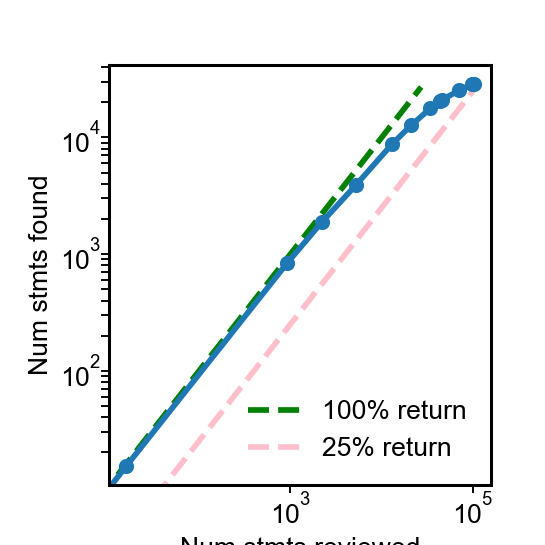

In [22]:
plt.figure(figsize=(2, 2), dpi=150)
plt.plot([0, 27000], [0, 27000], color='green', linestyle='--', label='100% return')
plt.plot([0, 100000], [0, 25000], color='pink', linestyle='--', label='25% return')
plt.plot(np.cumsum(num_rev), np.cumsum(num_found), marker='.')
plt.legend(loc='lower right', fontsize=pf.fontsize, frameon=False)
plt.xlabel('Num stmts reviewed')
plt.ylabel('Num stmts found')
ax = plt.gca()
pf.format_axis(ax)
plt.subplots_adjust(left=0.2)
plt.xscale('log')
plt.yscale('log')
plt.savefig(fig_path('return_on_curation', 'pdf'))

## Example interactions described in paper

KIF1C-RAB6A interaction:

In [89]:
for idx, stmt in enumerate(indra_stmts):
    if 'KIF1C' in str(stmt) and 'RAB6A' in str(stmt):
        print(idx, stmt, stmt.belief, len(stmt.evidence))

192715 Activation(RAB6A(), KIF1C()) 0.369 1
213492 Complex(GST(), KIF1C(), RAB6A()) 0.4543999999999999 1
329822 Complex(BICDL1(), KIF1C(), RAB6A()) 0.16496032261901458 2
355469 Complex(KIF1C(), KIFC1(), RAB6A()) 0.17531375577662733 1
355470 Complex(KIF1C(), RAB6A()) 0.8163005821840881 40
645461 Inhibition(RAB6A(), KIF1C()) 0.369 1


Evidence sources for the KIF1C-RAB6A interaction:

In [91]:
set([ev.source_api for ev in indra_stmts[355470].evidence])

{'reach', 'sparser'}